# MeerCRAB: MeerLICHT Classification of Real And Bogus using deep learning.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
# import load_data 
import matplotlib.pylab as plt
from keras.utils import np_utils
from time import gmtime, strftime
from sklearn.model_selection import train_test_split

from meerCRAB_code.load_data import load_image, get_data, shuffle_all
from meerCRAB_code.model import compile_model, model_save 
from meerCRAB_code.plot import optimsation_curve, feature_maps, plot_images
from meerCRAB_code.evaluation import model_prediction, save_classified_examples
from meerCRAB_code.util import makedirs, ensure_dir

#plt.rc('text', usetex=True)
#plt.rc('font',**{'family':'DejaVu Sans','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Parameters to change
nClasses   = 2  # The number of classes we are classifying: Real and Bogus
minPix     = 35 # The minimum pixel to be used from the image 
maxPix     = 65 # The maximum pixel to be used from the image
num_images = 'NRD'  # The number of images to used for training and testing either 'NRDS', 'NRD', 'NR', 'D', 'S'
training   = True# If we want to train the CNN, training = True, else it will load the existing model
model_cnn_name = 'NET3'  # The network name choose from: 'NET1','NET2','NET3', NET1_32_64','NET1_64_128','NET1_128_256'
threshold = 'threshold_9'#'threshold_9' or 'LCA'#This variable is used when loading the image- threshold atleast 9 people vetted a source as either real or bogus - threshold_9, can also use threshold_8
model_path= './meerCRAB_model/'
seed       = 3
output_directory = os.path.join("./meerCRAB_output/", model_cnn_name, strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
makedirs(output_directory)



## Load training and test set
Then convert labels to one hot encoding

In [3]:
# Load the training and test set
#X_train, y_train, ID_train = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/'+threshold+'_training_set.csv', remove_edge_cases=False)
#X_test, y_test, ID_test    = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/label_9_confused_image_data_with_label.csv', remove_edge_cases=False)

X_train, y_train, ID_train = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/'+threshold+'_training_set.csv', remove_edge_cases=False)
X_test, y_test, ID_test    = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/'+threshold+'_testing_set.csv', remove_edge_cases=False)


#X_train, y_train, ID_train = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/extra_analysis_data/'+threshold+'_training_set.csv', remove_edge_cases=False)
#X_test, y_test, ID_test    = get_data("meerlicht", n_images=num_images,  minPix=minPix, maxPix=maxPix, cropped=True, shuffle=True, fold='./data/extra_analysis_data/'+threshold+'_confused_sources.csv', remove_edge_cases=False)

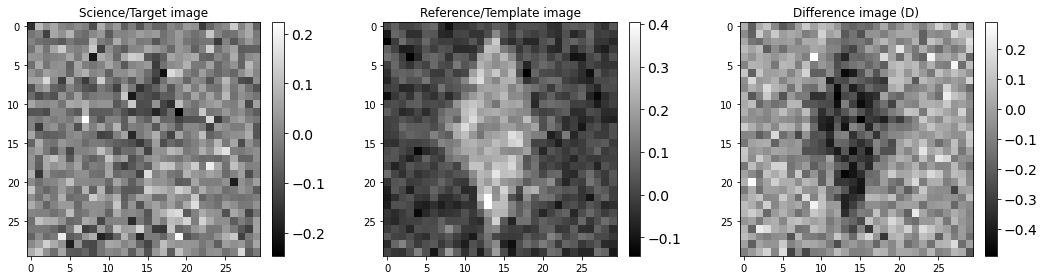

In [4]:
# Plot one example of the imag
plot_images(data=X_train[0:1], ID=ID_train[0:1], y_true=None, odir=None, savefig=False)

In [5]:
# shuffle training data  (potentially twice, via data augmentation as well)
X_train_, y_train_           = shuffle_all([X_train, y_train], len(y_train), seed=seed)

# Split the training set into 80% that will be used during training and 20% to be used during validation
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.2, random_state=42)

print("Total number of training instances: {}".format(str(len(y_train))))
print("Number of training examples in class 0: {}".format(str(len(np.where(y_train == 0)[0]))))
print("Number of training examples in class 1: {}".format(str(len(np.where(y_train == 1)[0]))))
print("Total number of validation instances: {}".format(str(len(y_val))))
print("Number of validation examples in class 0: {}".format(str(len(np.where(y_val == 0)[0]))))
print("Number of validation examples in class 1: {}".format(str(len(np.where(y_val == 1)[0]))))
print("Total number of test instances: {}".format(str(len(y_test))))
print("Number of test examples in class 0: {}".format(str(len(np.where(y_test == 0)[0]))))
print("Number of test examples in class 1: {}".format(str(len(np.where(y_test == 1)[0]))))


Total number of training instances: 2625
Number of training examples in class 0: 1292
Number of training examples in class 1: 1333
Total number of validation instances: 657
Number of validation examples in class 0: 333
Number of validation examples in class 1: 324
Total number of test instances: 1095
Number of test examples in class 0: 542
Number of test examples in class 1: 553


In [6]:
# Transform the vector of class integers into a one-hot encoded matrix using np_utils.to_categorical()
yTrain1h   = np_utils.to_categorical(y_train, nClasses)
yTest1h    = np_utils.to_categorical(y_test, nClasses)
yVal1h    = np_utils.to_categorical(y_val, nClasses)
print('The training set consists of {}'.format(X_train.shape))
print('The testing set consists of {}'.format(X_test.shape))
print('The validation set consists of {}'.format(X_val.shape))


The training set consists of (2625, 30, 30, 3)
The testing set consists of (1095, 30, 30, 3)
The validation set consists of (657, 30, 30, 3)


## Model training

In [7]:
'''
This function compile the model, apply early stopping to avoid overfitting
and also apply data augmentation if we set it to True

INPUTS:
    params: The model name we want to train for e.g 'NET1','NET2','NET3', NET1_32_64','NET1_64_128','NET1_128_256'
    img_shape: The shape of the image (100,100,3), or (30, 30, 4), or (X_train.shape[1],X_train.shape[2],X_train.shape[3])
    save_model_dir: The directory we want to save the history of the model [accuracy, loss]
    X_train, X_val: The training set and validation sey having shape (Nimages, 30pix, 30pix, 3 images)
    y_train, yval1h: The label for training and validation set- transform to one-hot encoding having shape (Nimages, 2) in the format array([[0., 1.],[1., 0.])
    batch_size: Integer values values can be in the range [32, 64, 128, 256]
    epoch: The number of iteration to train the network. Integer value varies in the range [10, 50, 100, 200, ...]
    lr: The learning rate for the optimisation values can vary from [0.1, 0.01, 0.001, 0.0001]
    class_weight: If we want the model to give more weights to the class we are interested then set it to {0:0.25,1:0.75} or None
    early_stopping: Stop the network from training if val_loss stop decreasing if TRUE
    save_model: set TRUE to save the model after training
    data_augmentation: set TRUE if we want to apply data augmentation

OUTPUTS:
    history: The logs of the accuracy and loss during optimization
    modelCNN: The fully trained model
lr=0.0002
'''
if training:
    history_, modelcnn = compile_model(params=model_cnn_name,img_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]),\
                        save_model_dir=model_path+model_cnn_name+'_'+threshold+'_'+num_images, X_train=X_train, y_train=yTrain1h, X_val=X_val, yval1h=yVal1h, \
                        batch_size=64, epochs=200, lr=0.0002, class_weight = None,early_stopping=True,save_model=True,data_augmentation=True)
    # save model to disk so that we don't need to retrain the model each time
    #model_save = model_save(modelcnn, model_name=model_cnn_name+'_'+threshold+'_'+num_images, model_path=model_path)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 512)       14336     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 512)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 1024)      4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 1024)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 1024)        0         
_________________________________________________________________
con

KeyboardInterrupt: 

## Prediction on Test set

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loaded model from disk
1095/1095 [==============================] - 0s 305us/step
Confusion matrix, without normalization
[[539   3]
 [  3 550]]


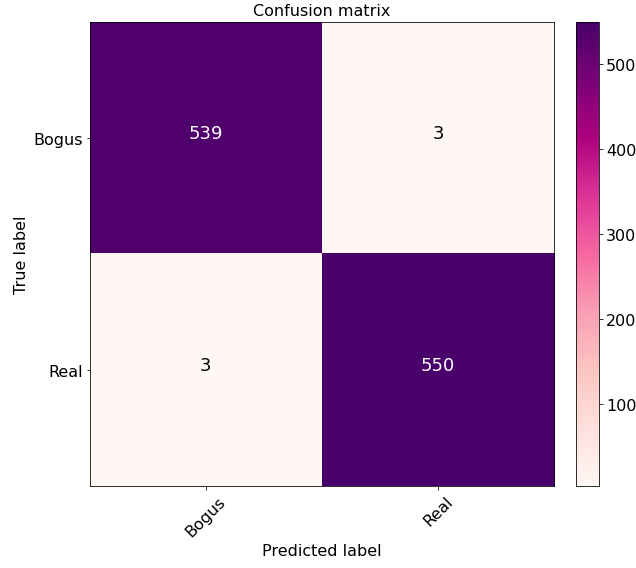

In [8]:
'''
Function to evaluate the trained model

INPUTS:
    fit_model: if load_model is False, it will fit the existing model that just trained, for e.g modelCNN, Else, it should be NONE
    odir: The directory to save the plots
    model_name: if load_model is True, model_name = 'NET1','NET2','NET3', NET1_32_64','NET1_64_128','NET1_128_256', Either of them
    X_test, y_test: Evaluate the trained model on a sample of test set having images and its label
    classes: List with the names of the classes considered. Used to label confusion matrix. 
    cm_norm: True if we want the conf_matrix to be betwwen 0 to 1 or False if we want the number of samples correctly classified
    load_model: True if we want to use an already pre-trained model, else False

OUTPUTS:
    ypred: An array of prediction for the test set array[[0 1 0 0 1 ....]]
    balanced_accuracy, MCC, conf_mat: The metrics  values when evaluating the trained model 
    misclassified: An array of indices from the test set indices that indicates which indices (images) got misclassified
    fit_model: return the train model
    correct_classification: An array of indices from the test set indices that indicates which indices (images) are correctly classified
    probability: The overall probability of each candidate varies betwwen 0 to 1. For a candidate, it outputs prob = [0.1, 0.9], this
                 candidate is therefore a real candidate with prob 0.9 and has a probability of 0.1 that it is bogus
'''

model_to_load = model_cnn_name+'_'+threshold+'_'+num_images
ypred, balance_accuracy, MCC, conf_mat, misclassified, model_loaded, correct_classification, probability = model_prediction(fit_model=None, odir=output_directory,model_name=model_to_load, X_test=X_test, y_test=y_test, model_path=model_path,classes=["Bogus" , "Real"], cm_norm=False, load_model=True)



## Plot the feature maps for the first convolutional neural for the real and bogus

In [9]:
#y_train[0]

0 conv2d_1 (?, 28, 28, 512)
3 conv2d_2 (?, 12, 12, 1024)
6 conv2d_3 (?, 4, 4, 2048)


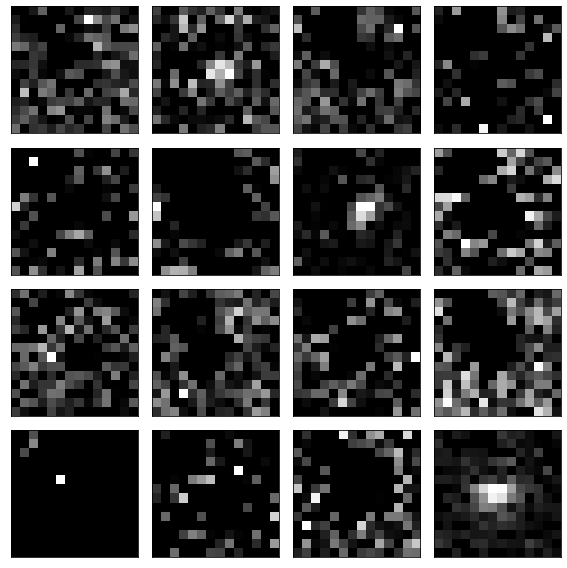

In [10]:
bogus_fm = feature_maps(model= model_loaded, x_train=X_train, y_train = y_train, img_index=0, ofname=os.path.join(output_directory, "feature_map_bogus.pdf"))


0 conv2d_1 (?, 28, 28, 512)
3 conv2d_2 (?, 12, 12, 1024)
6 conv2d_3 (?, 4, 4, 2048)


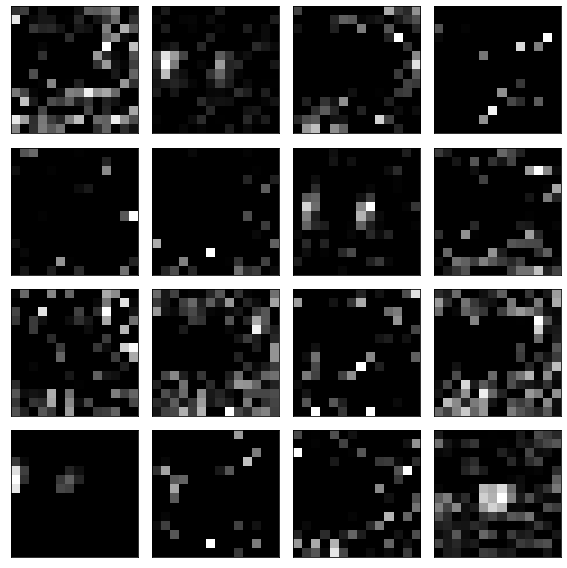

In [11]:
real_fm = feature_maps(model = model_loaded, x_train=X_train, y_train = y_train, img_index=1, ofname=os.path.join(output_directory, "feature_map_real.pdf"))


## Plot Optimization curves

In [12]:
if training:
    curves_loss_accuracy = optimsation_curve(history_,plot_dir1=os.path.join(output_directory, "Accuracy.pdf"),plot_dir2=os.path.join(output_directory, "Loss.pdf"))

## Plotting all misclassification

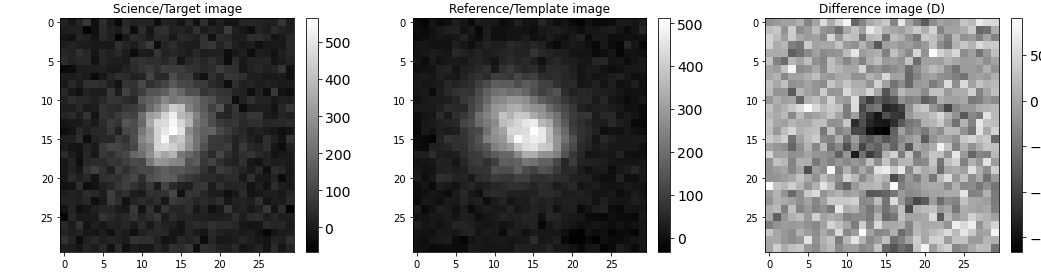

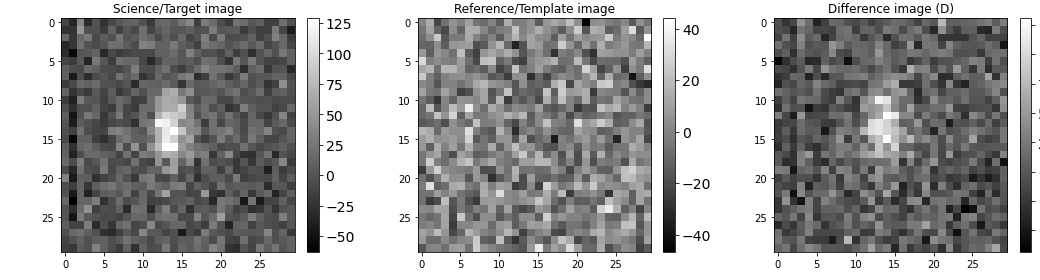

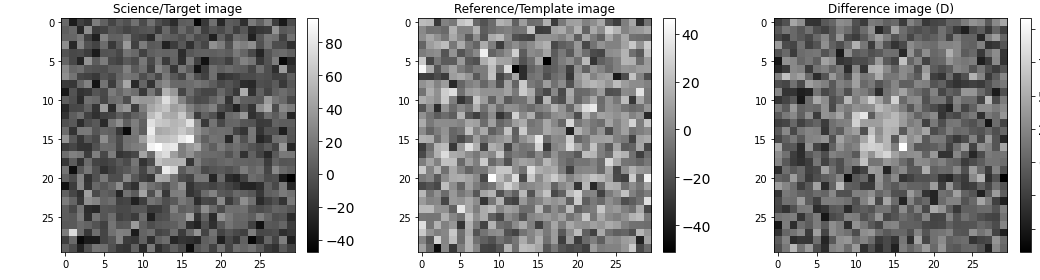

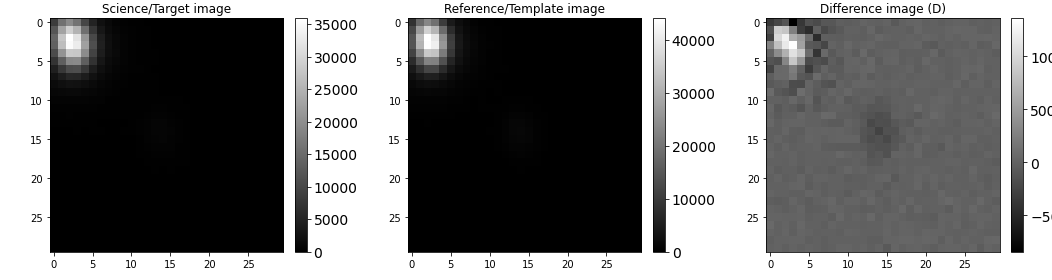

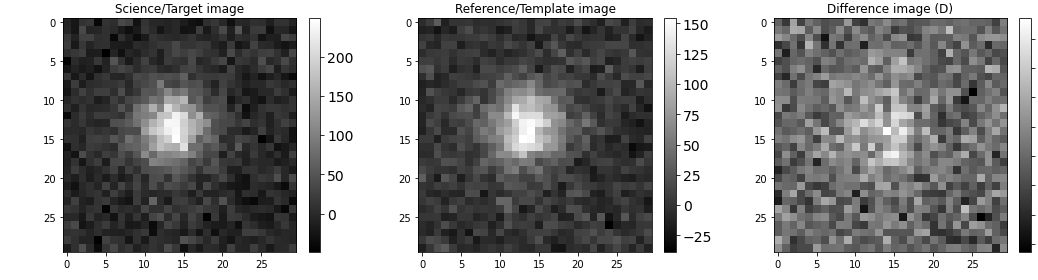

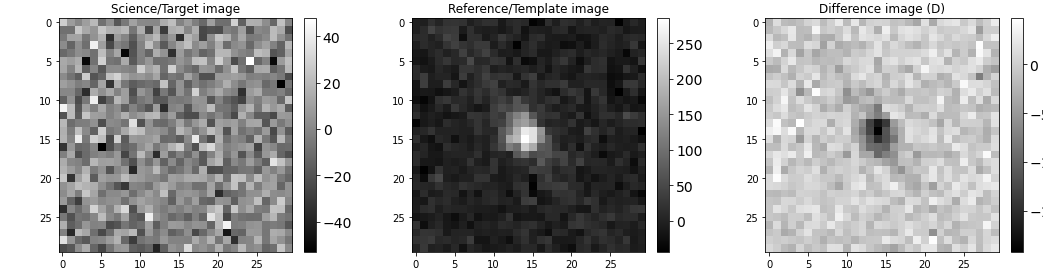

In [13]:
misclassified_array = misclassified
y_true              = y_test[misclassified_array]
ID_misclassified    = ID_test[misclassified_array]
misclassified_img   = X_test[misclassified_array]
if num_images != 'D' or num_images !='S':
    plot_images(misclassified_img*255.,ID_misclassified, y_true, odir=output_directory+'/misclassified_examples/', savefig=True)


# Save probability of correctly classified real and bogus in csv file

In [14]:
overall_probability_real, correctly_classified_bogus, correctly_classified_real=save_classified_examples(X_test, y_test, ID_test, correct_classification, probability,\
                                                                               odir_real=output_directory+'/classified_examples/1/',
                                                                               odir_bogus=output_directory+'/classified_examples/0/',savecsv = True)


In [15]:
overall_probability_real

,transientid,ML_PROB_REAL
0,844750,1.000000e+00
1,2673646,2.116457e-05
2,155823,5.367654e-27
3,553776,2.422633e-04
4,2298829,6.071998e-08
...,...,...
1090,1107291,1.000000e+00
1091,3000879,1.000000e+00
1092,6873,1.000000e+00
1093,140840,4.140563e-11


In [16]:
overall_prediction_table = pd.concat([overall_probability_real,pd.DataFrame(y_test,columns=['y_true'])],axis=1)
overall_prediction_table.to_csv(output_directory+'/classified_examples/overall_probability.csv', index=None)
overall_prediction_table

,transientid,ML_PROB_REAL,y_true
0,844750,1.000000e+00,1
1,2673646,2.116457e-05,0
2,155823,5.367654e-27,0
3,553776,2.422633e-04,0
4,2298829,6.071998e-08,0
...,...,...,...
1090,1107291,1.000000e+00,1
1091,3000879,1.000000e+00,1
1092,6873,1.000000e+00,1
1093,140840,4.140563e-11,0


# Analysis of ML Probability output P(Real)

In [17]:
misclassified_prob = pd.DataFrame()
for i in ID_misclassified:
    extract_rows = overall_probability_real[overall_probability_real['transientid']==i]
    misclassified_prob = misclassified_prob.append(extract_rows)

In [18]:
real = overall_probability_real[overall_probability_real['ML_PROB_REAL']>=0.5]
bogus = overall_probability_real[overall_probability_real['ML_PROB_REAL']<0.5]
print('Number of candidate classified as Real is {}'.format(real.shape[0]))
print('Number of candidate classified as Bogus is {}'.format(bogus.shape[0]))

Number of candidate classified as Real is 553
Number of candidate classified as Bogus is 542


Substituting symbol P from STIXNonUnicode
Substituting symbol P from STIXNonUnicode
Substituting symbol P from STIXNonUnicode
Substituting symbol P from STIXNonUnicode


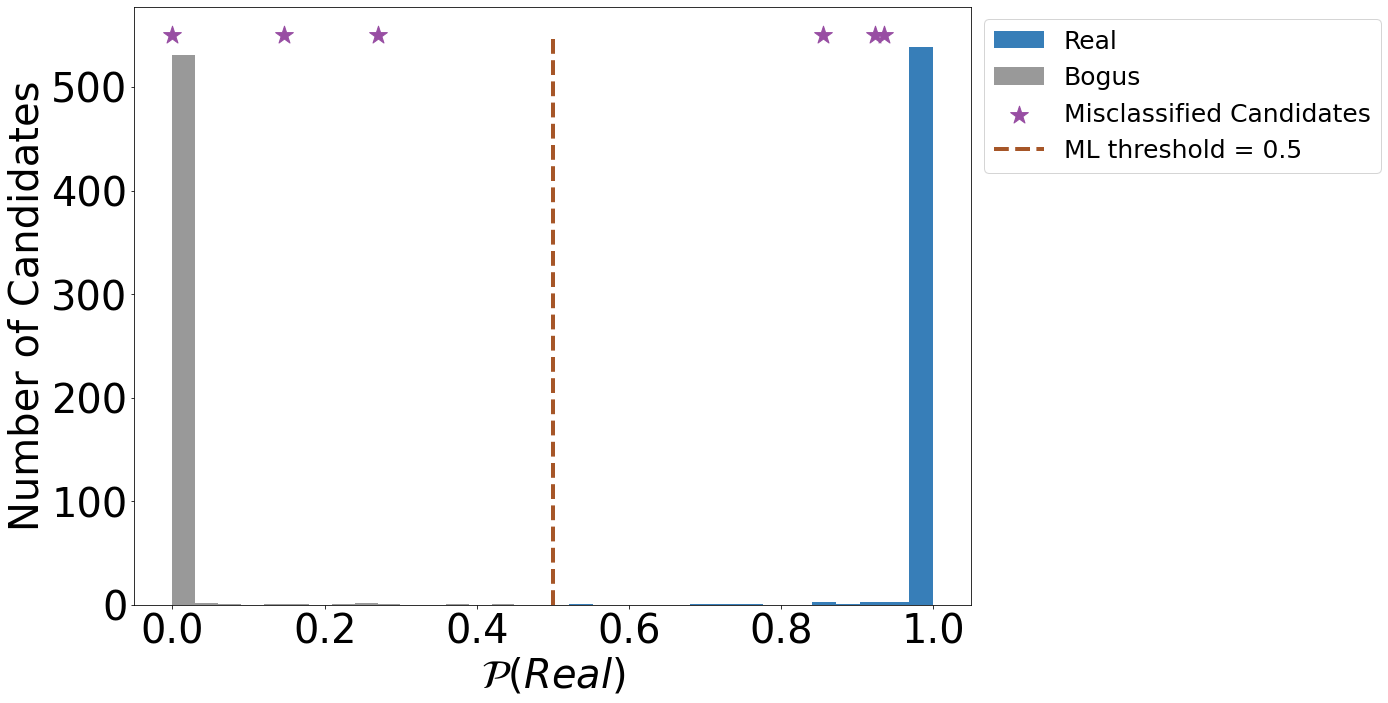

In [28]:
fontSize = 40
plt.figure(figsize=(15,11))
plt.hist(real['ML_PROB_REAL'],color='#377eb8',bins=15, label='Real')
plt.hist(bogus['ML_PROB_REAL'],color='#999999',bins=15,label='Bogus')
plt.scatter(misclassified_prob['ML_PROB_REAL'],[550]*misclassified_prob.shape[0], marker='*', s=350, color='#984ea3',label='Misclassified Candidates')
plt.vlines(0.5, ymin=0, ymax=550, linestyles='dashed',lw=4,label='ML threshold = 0.5',color='#a65628')
plt.xlabel("$\mathcal{P}(Real)$",fontsize=fontSize)
plt.ylabel("Number of Candidates",fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':25},bbox_to_anchor=(1,1.0))
makedirs(output_directory+'/plots/')
plt.savefig(output_directory+'/plots/ML_probability_output.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()